In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Instanziieren von Weights & Bias Backend und Installieren der benötigten Pakete 

In [36]:
import wandb
from kaggle_secrets import UserSecretsClient

# Greift auf hinterlegten Key "wandb_key" in Add-ons -> Secrets zu 
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb_key")

In [37]:
!pip install -q transformers shap
!pip install -U -q jupyterlab ipywidgets jupyterlab-widgets

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


In [38]:
!wandb login $wandb_key

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [39]:
%env WANDB_LOG_MODEL=true

env: WANDB_LOG_MODEL=true


In [40]:
wandb.init('finetuning-tweets')

eval/Acc,▁▁▃▁▅▅▅▇██▆█▅▆▄▅▆▅▆▅▅▄
eval/f1,▂▂▄▁▅▆▆▇██▇█▆▇▅▆▇▆▆▆▆▅
eval/loss,▄▄▂▄▁▂▁▂▃▁▄▂▅▅▄▆▆▆▇███
eval/runtime,▁▁▃▆▃▅▆▇▆▆▅▅▅▅▄▅▅█▆▆▇▇
eval/samples_per_second,██▅▃▆▄▃▂▃▃▄▄▄▄▅▄▄▁▃▃▂▂
eval/steps_per_second,██▅▃▆▄▃▂▃▃▄▄▄▄▅▄▄▁▃▃▂▂
test/Acc,▁
test/f1,▁
test/loss,▁
test/runtime,▁█
test/samples_per_second,▁█


# Laden der Daten als transformers.Dataset

In [41]:
from datasets import load_dataset, Dataset

train_ds = load_dataset("csv", data_files="/kaggle/input/nlp-getting-started/train.csv")
test_ds = load_dataset("csv", data_files="/kaggle/input/nlp-getting-started/test.csv")

# Splitten in Datensätze

In [42]:
from sklearn.model_selection import train_test_split

train_ds.set_format(type="pandas")
print(train_ds)
train_df = train_ds["train"][:]
train_df, val_df = train_test_split(train_df, test_size=0.2)

test_ds.set_format(type="pandas")
print(test_ds)
test_df = test_ds["train"][:]
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target'],
        num_rows: 7613
    })
})
DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text'],
        num_rows: 3263
    })
})
(6090, 5)
(1523, 5)
(3263, 4)


# Feature Selection

In [43]:
print(train_df)
train_df.drop(['keyword', 'location'], axis=1, inplace=True)
train_df.rename(columns={'target': 'labels'}, inplace=True)
val_df.drop(['keyword', 'location'], axis=1, inplace=True)
val_df.rename(columns={'target': 'labels'}, inplace=True)
test_df.drop(['keyword', 'location'], axis=1, inplace=True)
train_df.head()

         id           keyword                     location  \
2519   3619        desolation                      Arizona   
5019   7159          mudslide  Co. Tyrone Northern Ireland   
2353   3388        demolition                New York, USA   
5294   7561          outbreak                United States   
986    1431    body%20bagging      Sydney, New South Wales   
...     ...               ...                          ...   
3747   5324              fire                         None   
256     364      annihilation                         None   
3198   4590  emergency%20plan              Chapel Hill, NC   
200     281         ambulance    VISIT MY YOUTUBE CHANNEL.   
7295  10439      wild%20fires                 Twitterville   

                                                   text  target  
2519  Did Josephus get it wrong about Antiochus Epip...       0  
5019  Looks like a mudslide and tastes like rubber o...       0  
2353  @MentalHealthGov like AHHhhh fix the ALEC made...  

,id,text,labels
2519,3619,Did Josephus get it wrong about Antiochus Epip...,0
5019,7159,Looks like a mudslide and tastes like rubber o...,0
2353,3388,@MentalHealthGov like AHHhhh fix the ALEC made...,0
5294,7561,Families to sue over Legionnaires: More than 4...,1
986,1431,@ohmyloz @RondaRousey who is bagging her body ...,0


# Laden des Models und batching der Datensätze

In [44]:
from transformers import AutoTokenizer

# Es lassen sich auch andere Encoder-basierte Modell ckpts verwenden
# model_ckpt = "distilbert-base-uncased"
model_ckpt = 'distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [45]:
def preprocess_function_batch(examples):
    return tokenizer(examples["text"], padding='max_length', truncation=True, return_tensors='pt', max_length=280)

In [46]:
batch_size = 16
encoded_train_dataset = train_dataset.map(preprocess_function_batch, batched=True, batch_size = batch_size)
encoded_val_dataset = val_dataset.map(preprocess_function_batch, batched=True, batch_size = batch_size)
encoded_test_dataset = test_dataset.map(preprocess_function_batch, batched=True,batch_size = batch_size)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [47]:
# Beispiel für das encodieren eines samples
example = encoded_train_dataset[0]
print(example.keys())
print(example['input_ids'])
print(len(example['input_ids']))

dict_keys(['id', 'text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'])
[0, 20328, 3351, 687, 120, 24, 1593, 59, 33604, 687, 14230, 28778, 11372, 8, 5, 2060, 43539, 9, 4762, 35626, 116, 1163, 55, 35, 2054, 640, 90, 4, 876, 73, 18514, 267, 466, 347, 438, 975, 605, 401, 330, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [48]:
# Beispiel für das decodieren des samples
tokenizer.decode(example['input_ids'])

'<s>Did Josephus get it wrong about Antiochus Epiphanes and the Abomination of Desolation? Read more: http://t.co/FWj9CcYw6k</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [49]:
# Beispiel Label
example['labels']

0

In [50]:
encoded_train_dataset.set_format("torch")

In [51]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2)

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
task = "tweets"
model_output_dir = f"{model_ckpt}-finetuned-{task}"
print(model_output_dir)
run_count = 1
run_name = f"{model_output_dir}_run_{run_count}"
print(run_name)

distilroberta-base-finetuned-tweets
distilroberta-base-finetuned-tweets_run_1


Siehe für Beschreibung der folgenden Trainer Argumente den folgenden [Medium Artikel](https://medium.com/nlplanet/bert-finetuning-with-hugging-face-and-training-visualizations-with-tensorboard-46368a57fc97)

In [53]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir=model_output_dir,
    overwrite_output_dir = True,
    evaluation_strategy="steps",
    eval_steps=50,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=250,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    run_name = run_name,
    report_to="wandb"
#     report_to='none'
)

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead


In [54]:
from transformers import EvalPrediction
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import torch

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2)
    
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Compute F1-score
    f1 = f1_score(labels, predictions, average="weighted") 
    acc = accuracy_score(labels, predictions)
    return {"Acc": acc, "f1": f1}

# Training des pretrained Models mit hf Trainer Klasse

In [55]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Acc,F1
50,No log,0.425420,0.822718,0.820115
100,0.531100,0.480220,0.778070,0.762442
150,0.531100,0.420731,0.822062,0.822145
200,0.421700,0.401184,0.829941,0.829531
250,0.421700,0.411985,0.819435,0.819520
300,0.430800,0.410712,0.822062,0.821796
350,0.430800,0.439513,0.826001,0.825912
400,0.399600,0.382363,0.833224,0.830271
450,0.399600,0.398988,0.835850,0.834808
500,0.352000,0.397074,0.826658,0.824648


TrainOutput(global_step=1143, training_loss=0.36503696775394684, metrics={'train_runtime': 434.6558, 'train_samples_per_second': 42.033, 'train_steps_per_second': 2.63, 'total_flos': 1323535594852800.0, 'train_loss': 0.36503696775394684, 'epoch': 3.0})

# Evaluation des trainierten Models

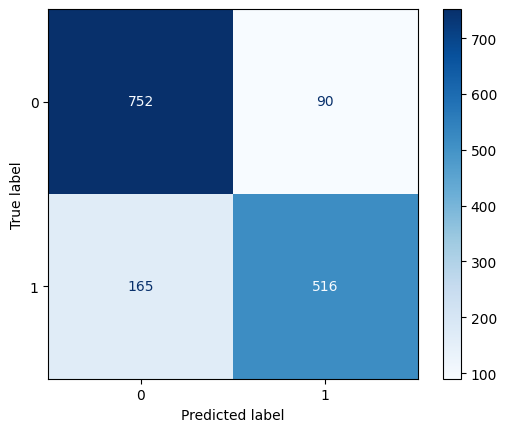

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

val_predictions = trainer.predict(encoded_val_dataset)

logits = val_predictions.predictions
predicted_labels = np.argmax(logits, axis=1)
true_labels = val_predictions.label_ids

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")


In [57]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, accuracy_score
)

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8326
Precision: 0.8515
Recall: 0.7577
F1-score: 0.8019


# Analyse der Vorhersagen

In [58]:
false_predictions = np.where(predicted_labels != true_labels)[0][:5]
true_predictions =  np.where(predicted_labels == true_labels)[0][:5]

# Kann man auch mal auf die falschen Vorhersagen ändern
predictions = true_predictions

prediction_examples = []
for idx in predictions:
    example = encoded_val_dataset[int(idx)]
    original_text = example['text']
    true_label = true_labels[idx]
    predicted_label = predicted_labels[idx]
    prediction_examples.append((original_text, predicted_label, true_label))

for i, item in enumerate(prediction_examples):
    if i == 150:
        break
    else:
        print(f"{i+1}. Text: {item[0]}\n   True Label: {item[2]}\n   Predicted Label: {item[1]}\n")


1. Text: I liked a @YouTube video http://t.co/N95IGskd3p Minecraft: Episode 2 'Blaze Farm Beginnings!'
   True Label: 0
   Predicted Label: 0

2. Text: Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) - http://t.co/dI5aRr6HQ6
   True Label: 0
   Predicted Label: 0

3. Text: matako_3: Breaking news! Unconfirmed! I just heard a loud bang nearby. in what appears to be a blast of wind from my neighbour's ass.
   True Label: 0
   Predicted Label: 0

4. Text: So it looks like my @SoundCloud profile shall be no more! Nothing left to offer! DJ mixes obliterated ?? #byebyesoundcloud
   True Label: 0
   Predicted Label: 0

5. Text: Cop injured in gunfight as militants attack Udhampur police post: Suspected militants attacked a police post i... http://t.co/2h0dPMv2Ef
   True Label: 1
   Predicted Label: 1



# Erklärung einzelner Vorhersagen mittels Shapley Values

Für mehr Infos bezüglich Shapley Values ist die [Dokumentation](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.html) hilfreich

In [59]:
import shap

def predict(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.logits.numpy()

In [60]:
import transformers

shap_model = trainer.model
shap_model.eval()
pred = transformers.pipeline(
    "text-classification",
    model=shap_model,
    tokenizer=tokenizer,
    device=0,
    return_all_scores=True,
)

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.


In [61]:
explainer = shap.Explainer(pred)

# Beispiele für korrekte Vorhersagen:
# Erster Tweet ist ein echtes Disaster -> Label: 1
# Zweiter Tweet ist ein fake Diaster -> Label: 0

text_examples = [
    "@FLGovScott We allow Farrakhan to  to challenge 10000 males to rise up &amp; commit mass murder as he just did in Miami? http://t.co/gV84WNhB7S",
    "I'm crying that song just ended setting myself on fire  https://t.co/i2El5aCrRW",
]

shap_values = explainer(text_examples)

In [62]:
shap.plots.text(shap_values)

# Exportieren der Vorhersagen auf den Test Daten

In [63]:
test_predictions = trainer.predict(encoded_test_dataset)
test_predictions_argmax = np.argmax(test_predictions[0], axis=1)
print(len(test_predictions_argmax))

3263


In [64]:
import torch

# Beispiel für die Erklärung des Unterschieds zwischen Logits und Wahrscheinlichkeiten
first_logit = test_predictions[0][0]
print(f'Logits:', first_logit)
first_logit = torch.from_numpy(first_logit)
probs = torch.softmax(first_logit, dim=0)
print('Probs:', probs)

Logits: [-1.60193    1.5353788]
Probs: tensor([0.0416, 0.9584])


In [65]:
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': test_predictions_argmax
})
submission_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [66]:
value_counts = submission_df['target'].value_counts()
print("\nCounts of each unique entry:")
print(value_counts)


Counts of each unique entry:
target
0    2043
1    1220
Name: count, dtype: int64


In [67]:
submission_df.to_csv("submission.csv", index=False)